In [77]:
!pip install kneed

In [78]:
import sys
sys.path.append("../../")

from src.analysis.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Basic configuration
DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [79]:
def load_and_prepare_data(file_path):

    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

##### Loade Price Data

In [80]:
import toml

with open("../config.toml", "r") as f:
    config = toml.load(f)
    
price_matrix, symbols = load_and_prepare_data(config['data']['raw_data_path'])

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 100
Total trading days: 1022



$$ \text{Rendite} = \frac{1}{T} \sum_{t=1}^{T} \frac{P_t - P_{t-1}}{P_{t-1}} \times \text{Trading days per year} $$


$$ \text{Volatilität} = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} \left( \frac{P_t - P_{t-1}}{P_{t-1}} - \mu \right)^2} \times \sqrt{\text{Trading days per year}} $$


In [81]:
def calculate_metrics(price_matrix):
    returns = price_matrix.pct_change().mean() * DATE_CONFIG['TRADING_DAYS_PER_YEAR']
    metrics = pd.DataFrame(returns, columns=['returns'])
    metrics['volatility'] = price_matrix.pct_change().std() * np.sqrt(DATE_CONFIG['TRADING_DAYS_PER_YEAR'])
    return metrics

##### Validate metrics

In [82]:
metrics = calculate_metrics(price_matrix)
print("Erste 5 Zeilen der Metriken:")
print(metrics.head())
print("\nBeschreibung der Metriken:")
print(metrics.describe())

Erste 5 Zeilen der Metriken:
         returns  volatility
symbol                      
ADDRO  -0.372181    0.579507
AFIWZ  -0.750022    0.573694
AFQOF  -0.424683    0.601308
AQDMB  -1.143011    0.614840
ATIYU  -1.018191    0.583873

Beschreibung der Metriken:
          returns  volatility
count  100.000000  100.000000
mean    -0.832384    0.599206
std      0.303962    0.013116
min     -1.553117    0.572371
25%     -1.043832    0.587966
50%     -0.836795    0.600834
75%     -0.620924    0.610092
max     -0.179679    0.628898


##### Scale Transform
The StandardScaler transforms our features (returns and volatility) to have zero mean and unit variance, which eliminates the scale difference between our variables and prevents higher magnitude features from dominating. This standardization is crucial for many machine learning algorithms as it ensures that all features contribute equally to the model and helps prevent numerical instabilities during the optimization process.

In [83]:
def scale_metrics(metrics):
    scaler = StandardScaler()
    scaled = pd.DataFrame(
        scaler.fit_transform(metrics),
        columns=metrics.columns,
        index=metrics.index
    )
    return scaled

In [84]:
X = scale_metrics(metrics)
print("Erste 5 Zeilen der skalierten Daten:")
print(X.head())
print("\nBeschreibung der skalierten Daten:")
print(X.describe())

Erste 5 Zeilen der skalierten Daten:
         returns  volatility
symbol                      
ADDRO   1.521643   -1.509434
AFIWZ   0.272325   -1.954898
AFQOF   1.348047    0.161058
AQDMB  -1.027077    1.197966
ATIYU  -0.614365   -1.174891

Beschreibung der skalierten Daten:
            returns    volatility
count  1.000000e+02  1.000000e+02
mean  -8.437695e-17  7.469581e-15
std    1.005038e+00  1.005038e+00
min   -2.383074e+00 -2.056249e+00
25%   -6.991433e-01 -8.612794e-01
50%   -1.458500e-02  1.247890e-01
75%    6.991830e-01  8.342100e-01
max    2.158142e+00  2.275252e+00


# Affinity Propagation Clustering

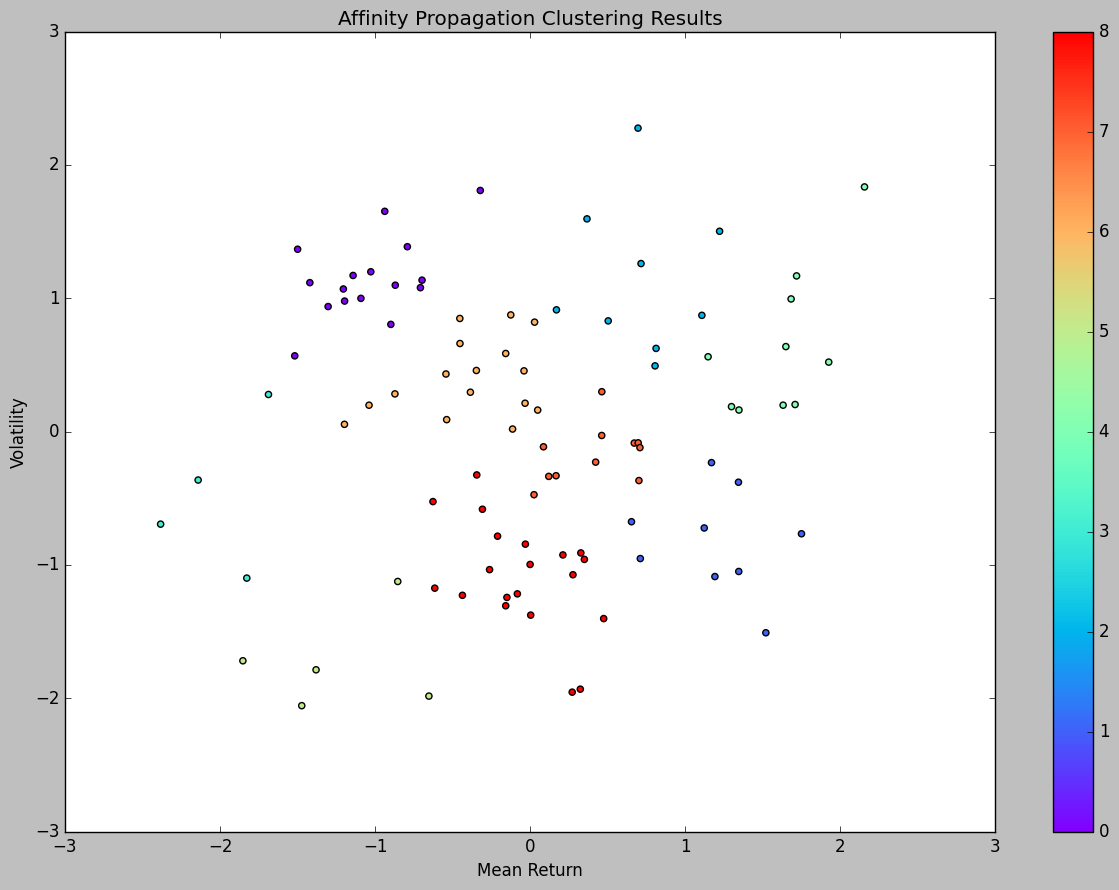

In [85]:
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

In [86]:
def get_top_pairs(X, ap, price_matrix, min_pairs=20, p_threshold=0.05):
    scores = []
    
    for cluster_id in np.unique(ap.labels_):
        cluster_mask = ap.labels_ == cluster_id
        cluster_symbols = X.index[cluster_mask]
        center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
        
        for i in range(len(cluster_symbols)):
            for j in range(i+1, len(cluster_symbols)):
                symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                
                dist1 = np.linalg.norm(X.loc[symbol1] - center)
                dist2 = np.linalg.norm(X.loc[symbol2] - center)
                center_dist = (dist1 + dist2) / 2
                
                profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                
                series1 = price_matrix[symbol1]
                series2 = price_matrix[symbol2]
                score, pvalue, _ = coint(series1, series2)
                
                if pvalue < p_threshold:
                    scores.append({
                        'pair': (symbol1, symbol2),
                        'center_dist': center_dist,
                        'profile_diff': profile_diff,
                        'pvalue': pvalue,
                        'cluster': cluster_id
                    })

    scores_df = pd.DataFrame(scores)

    scores_df['center_dist_norm'] = (scores_df['center_dist'] - scores_df['center_dist'].min()) / \
                                   (scores_df['center_dist'].max() - scores_df['center_dist'].min())
    scores_df['profile_diff_norm'] = (scores_df['profile_diff'] - scores_df['profile_diff'].min()) / \
                                    (scores_df['profile_diff'].max() - scores_df['profile_diff'].min())

    scores_df['combined_score'] = 0.6 * scores_df['center_dist_norm'] + \
                                 0.4 * scores_df['profile_diff_norm']
    
    scores_df = scores_df.sort_values('combined_score')
    
    while len(scores_df) < min_pairs and p_threshold < 0.1:
        p_threshold += 0.05
        scores = []
        for cluster_id in np.unique(ap.labels_):
            cluster_mask = ap.labels_ == cluster_id
            cluster_symbols = X.index[cluster_mask]
            center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
            
            for i in range(len(cluster_symbols)):
                for j in range(i+1, len(cluster_symbols)):
                    symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                    dist1 = np.linalg.norm(X.loc[symbol1] - center)
                    dist2 = np.linalg.norm(X.loc[symbol2] - center)
                    center_dist = (dist1 + dist2) / 2
                    profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                    score, pvalue, _ = coint(series1, series2)
                    
                    if pvalue < p_threshold:
                        scores.append({
                            'pair': (symbol1, symbol2),
                            'center_dist': center_dist,
                            'profile_diff': profile_diff,
                            'pvalue': pvalue,
                            'cluster': cluster_id
                        })
        
        scores_df = pd.DataFrame(scores)
        if len(scores) > 0:
            scores_df['center_dist_norm'] = (scores_df['center_dist'] - scores_df['center_dist'].min()) / \
                                          (scores_df['center_dist'].max() - scores_df['center_dist'].min())
            scores_df['profile_diff_norm'] = (scores_df['profile_diff'] - scores_df['profile_diff'].min()) / \
                                           (scores_df['profile_diff'].max() - scores_df['profile_diff'].min())
            scores_df['combined_score'] = 0.6 * scores_df['center_dist_norm'] + \
                                        0.4 * scores_df['profile_diff_norm']
            scores_df = scores_df.sort_values('combined_score')
    
    print(f"Found {len(scores_df)} pairs with p-value < {p_threshold}")
    return scores_df['pair'].tolist()[:min_pairs], scores_df[:min_pairs]

In [87]:
top_pairs, scores_df = get_top_pairs(X, ap, price_matrix, min_pairs=20)

Found 277 pairs with p-value < 0.05


The number of clusters is: 9


<Figure size 1200x600 with 0 Axes>

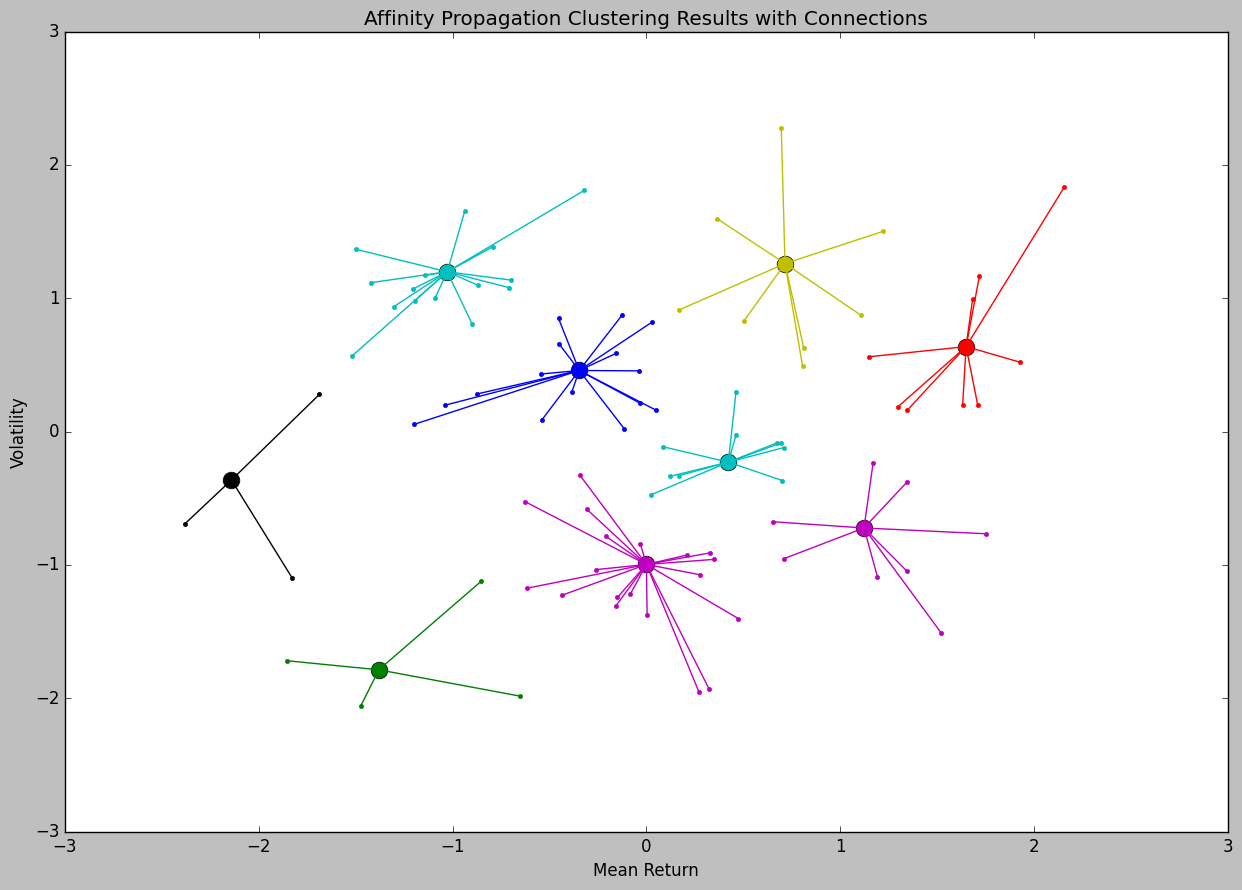

In [88]:
from itertools import cycle

#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation Clustering Results with Connections')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')
plt.show()

In [89]:
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())

cluster_size_limit = 1000
counts = clustered_series_ap.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print("Number of clusters:", len(ticker_count))
print("Number of Pairs:", (ticker_count*(ticker_count-1)).sum())

Number of clusters: 9
Number of Pairs: 1236


Analyzing pairs: 100%|██████████| 120/120 [00:02<00:00, 59.84it/s]



Analysis complete!
Found 46 cointegrated pairs
Total pairs analyzed: 120

Cluster 0 pairs:
AQDMB - EYWZV
AQDMB - MXUEC
AQDMB - QGMXV
AQDMB - ZQLND
BLZZB - EYCEP
BLZZB - GDXGP
BLZZB - KHDKY
BLZZB - USNZJ
CQUKB - EYCEP
CQUKB - GDXGP
CQUKB - KHDKY
CQUKB - MXUEC
CQUKB - QGMXV
CQUKB - USNZJ
EYCEP - GDXGP
EYCEP - UECLL
EYCEP - USNZJ
EYNBG - EYWZV
EYNBG - KHDKY
EYNBG - USNZJ
EYNBG - YICCW
EYNBG - ZQLND
EYWZV - GDXGP
EYWZV - KHDKY
EYWZV - QGMXV
EYWZV - USNZJ
EYWZV - YICCW
GDXGP - KHDKY
GDXGP - MXUEC
GDXGP - QGMXV
GDXGP - USNZJ
GDXGP - WYCMB
GDXGP - YICCW
GDXGP - ZQLND
KHDKY - QGMXV
KHDKY - USNZJ
MXUEC - QGMXV
MXUEC - UECLL
MXUEC - USNZJ
MXUEC - WYCMB
QGMXV - UECLL
QGMXV - USNZJ
QGMXV - WYCMB
QGMXV - YICCW
UECLL - USNZJ
YICCW - ZQLND


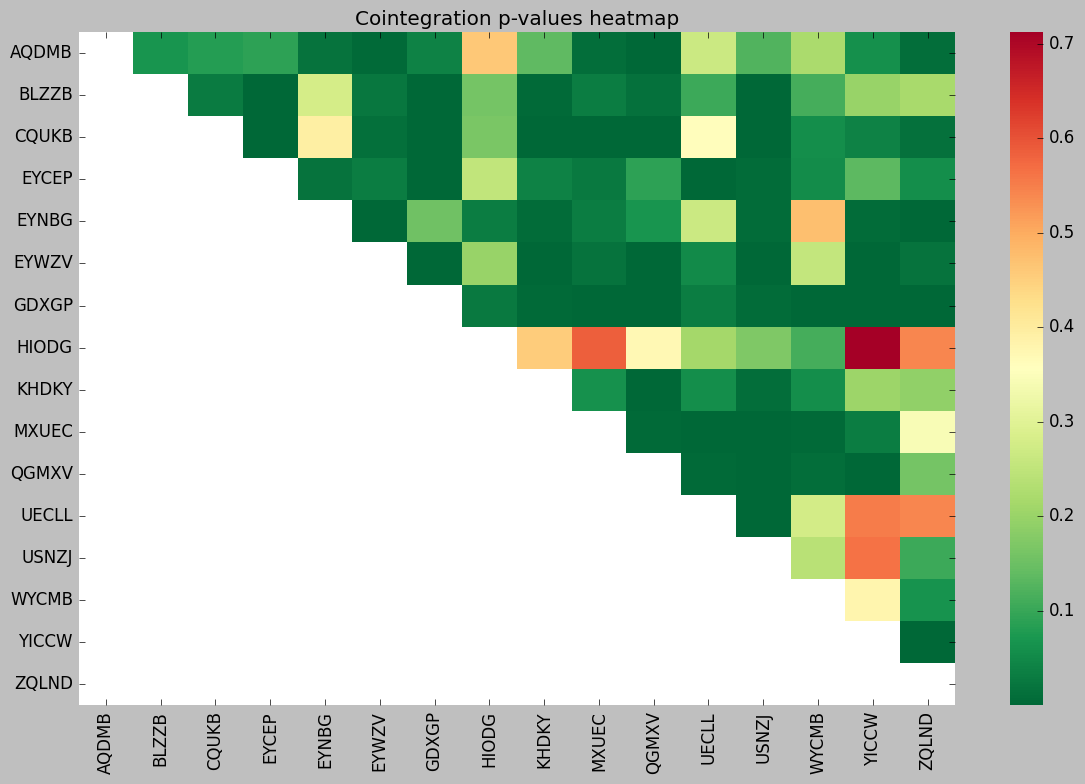

Analyzing pairs: 100%|██████████| 36/36 [00:00<00:00, 63.41it/s]



Analysis complete!
Found 9 cointegrated pairs
Total pairs analyzed: 36

Cluster 1 pairs:
ADDRO - GGOGP
ADDRO - STEPT
AYWVH - GGOGP
AYWVH - STEPT
GCUWK - STEPT
GGOGP - GULKY
GGOGP - KFZNC
KFZNC - STEPT
XTMGG - ZEZGC


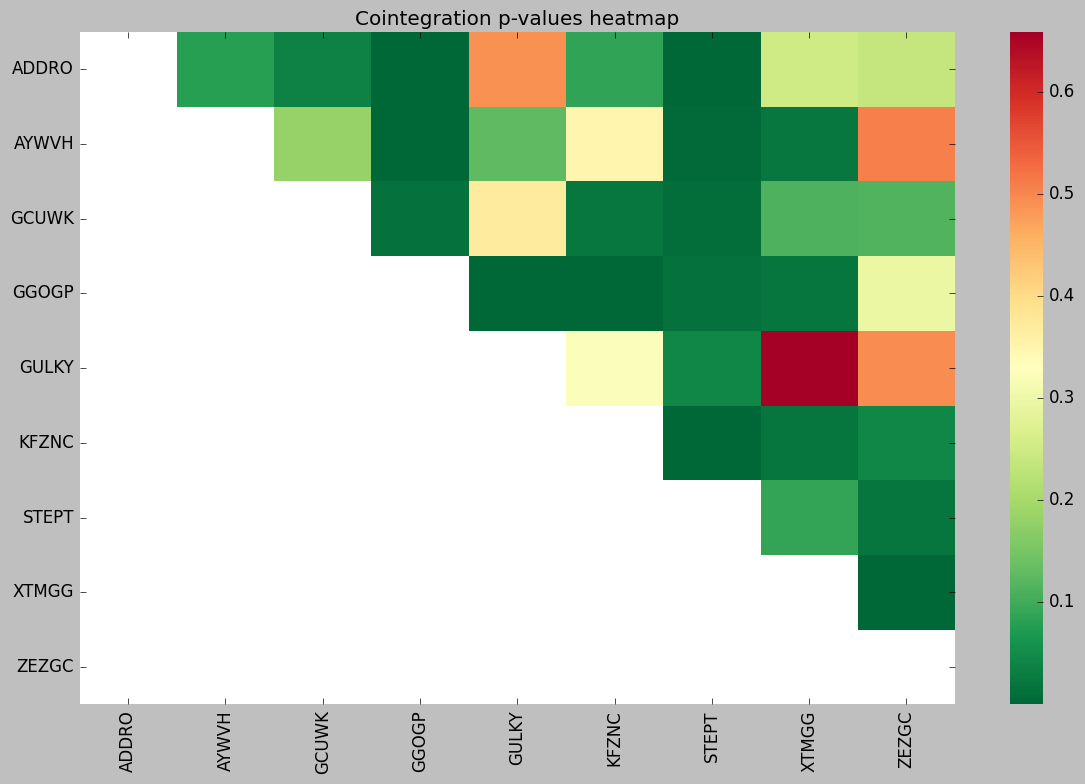

Analyzing pairs: 100%|██████████| 36/36 [00:00<00:00, 57.79it/s]



Analysis complete!
Found 6 cointegrated pairs
Total pairs analyzed: 36

Cluster 2 pairs:
GYWWJ - JAJTW
GYWWJ - KXPSW
GYWWJ - WIRKX
JAJTW - KXPSW
NMLTG - RNGQC
NMLTG - WIRKX


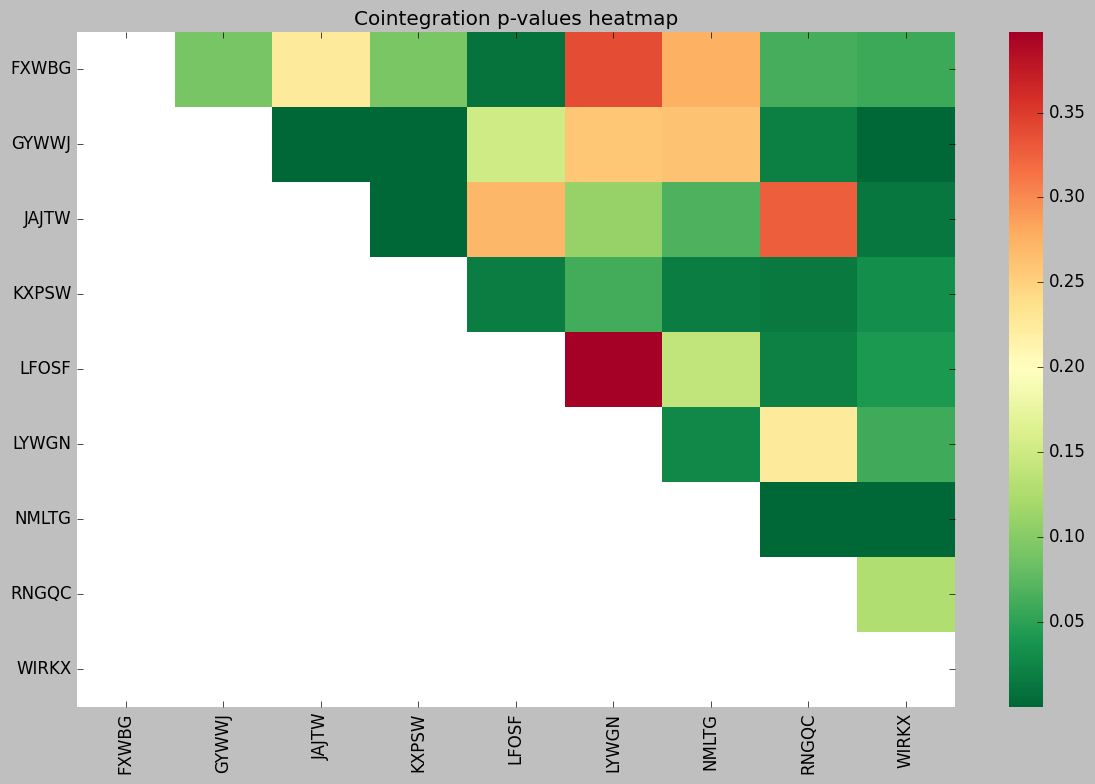

Analyzing pairs: 100%|██████████| 6/6 [00:00<00:00, 62.20it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 6

Cluster 3 pairs:
KQFSM - SBKOK


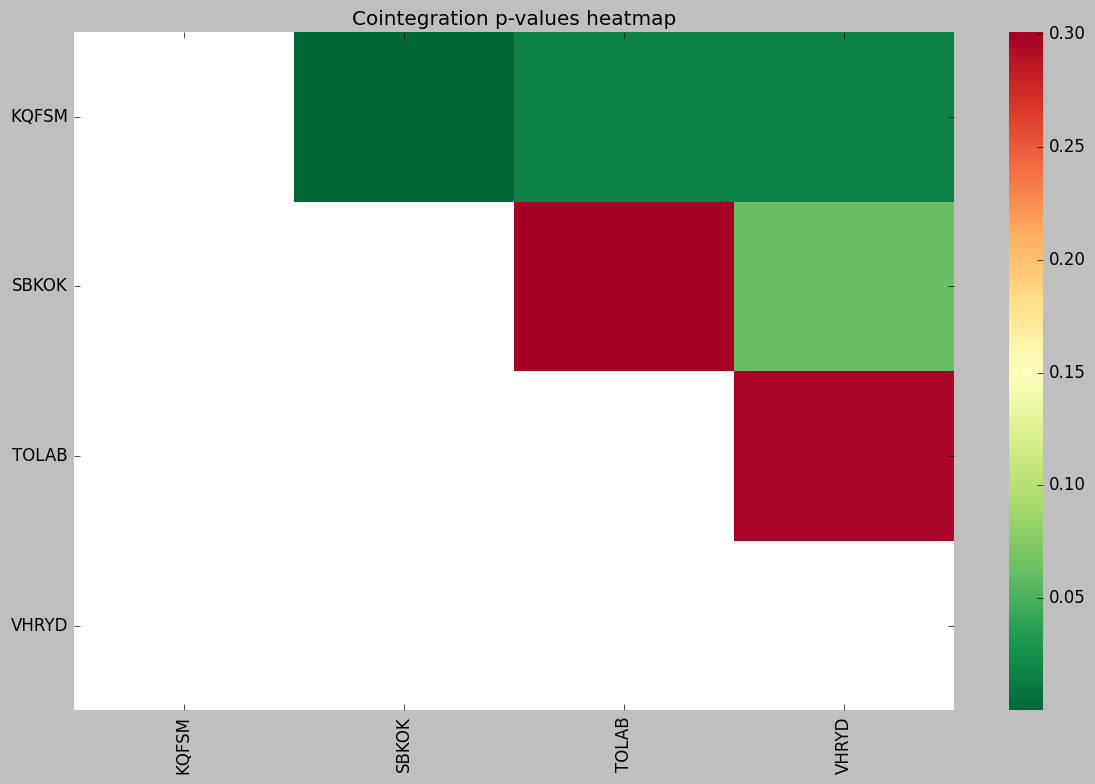

Analyzing pairs: 100%|██████████| 45/45 [00:00<00:00, 63.09it/s]



Analysis complete!
Found 5 cointegrated pairs
Total pairs analyzed: 45

Cluster 4 pairs:
AFQOF - FITJT
AFQOF - GSAYN
AFQOF - OSEHZ
FITJT - GSAYN
FITJT - OSEHZ


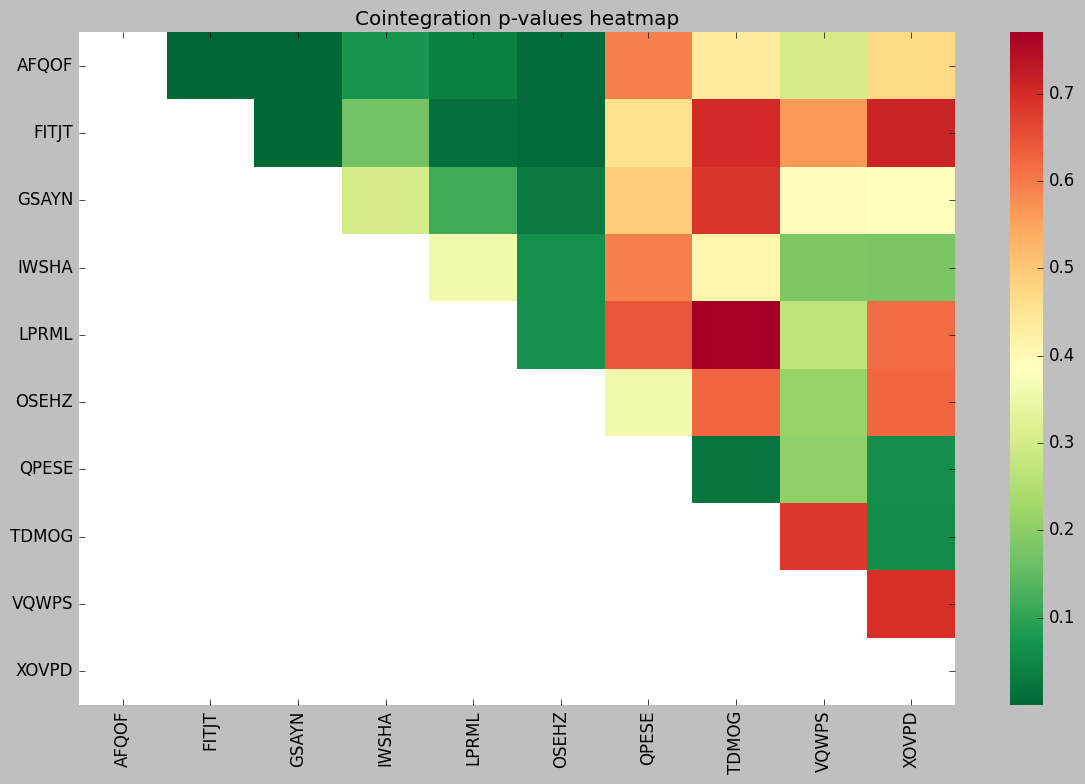

Analyzing pairs: 100%|██████████| 10/10 [00:00<00:00, 63.66it/s]



Analysis complete!
Found 4 cointegrated pairs
Total pairs analyzed: 10

Cluster 5 pairs:
GKRHI - LURZP
GKRHI - OTBPN
GKRHI - XPSNV
OTBPN - XPSNV


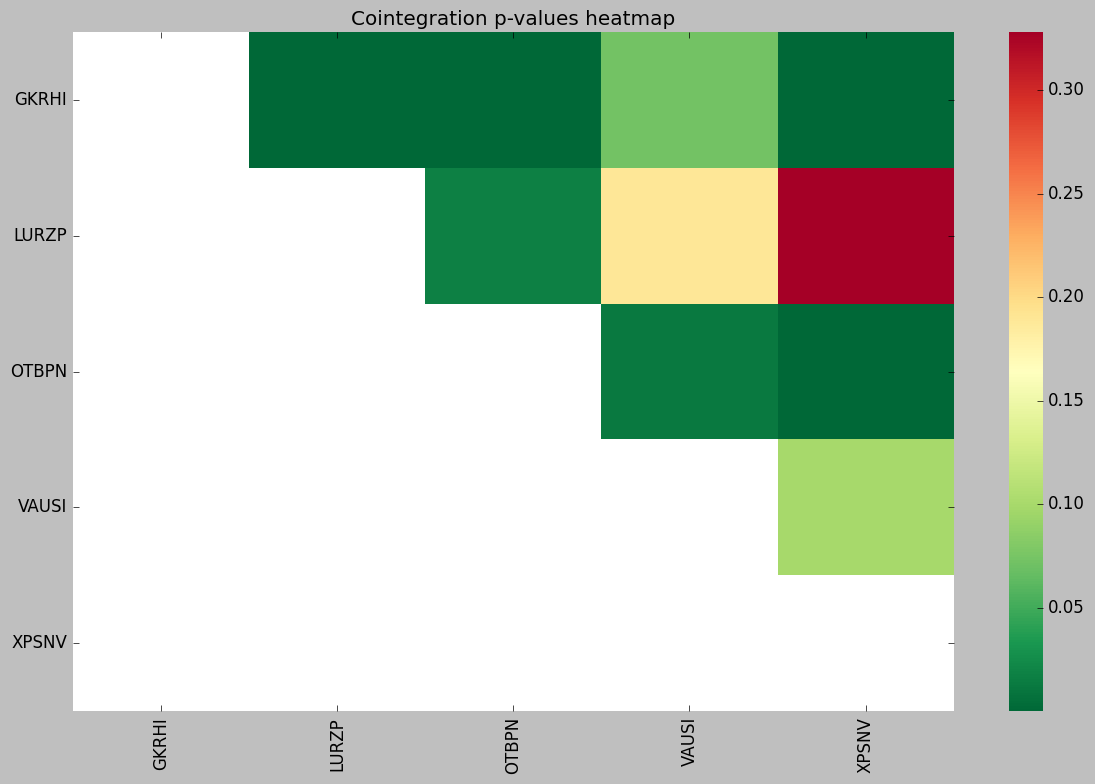

Analyzing pairs: 100%|██████████| 120/120 [00:01<00:00, 62.79it/s]



Analysis complete!
Found 16 cointegrated pairs
Total pairs analyzed: 120

Cluster 6 pairs:
FAIGF - RATUC
FDYOM - WVCYQ
FHCGC - TNQHC
FHCGC - XQHOA
IWSHI - RATUC
JAWEF - TNQHC
JAWEF - WVCYQ
QUQTY - SLTZH
RATUC - TRJBR
RATUC - WVCYQ
RATUC - XQHOA
RATUC - YKSBR
RATUC - ZVZYW
TNQHC - XQHOA
TRJBR - XQHOA
XQHOA - ZVZYW


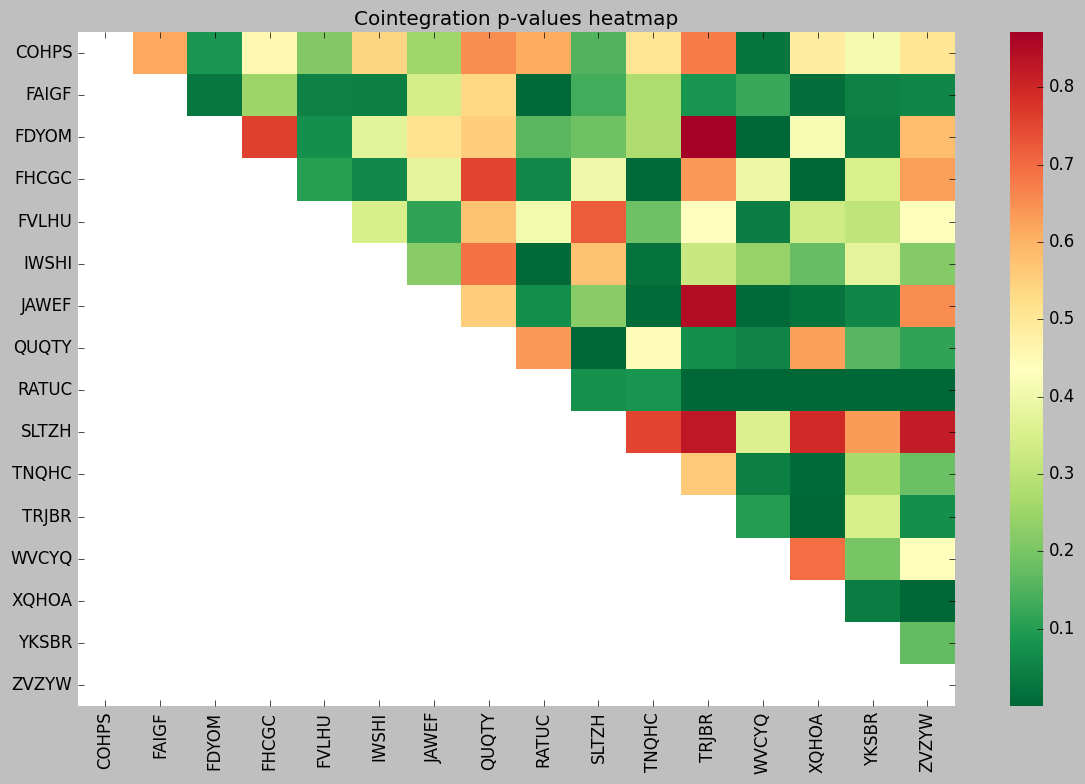

Analyzing pairs: 100%|██████████| 55/55 [00:00<00:00, 62.69it/s]



Analysis complete!
Found 13 cointegrated pairs
Total pairs analyzed: 55

Cluster 7 pairs:
FAGMW - GCAOZ
FAGMW - MDQAK
FAGMW - QJJFG
FAGMW - VSPZR
FAGMW - ZNZWA
GCAOZ - QJJFG
GCAOZ - QKZNY
GCAOZ - TOUNA
GCAOZ - VSPZR
GCAOZ - ZNZWA
QJJFG - VSPZR
TOUNA - VSPZR
TOUNA - XWHQP


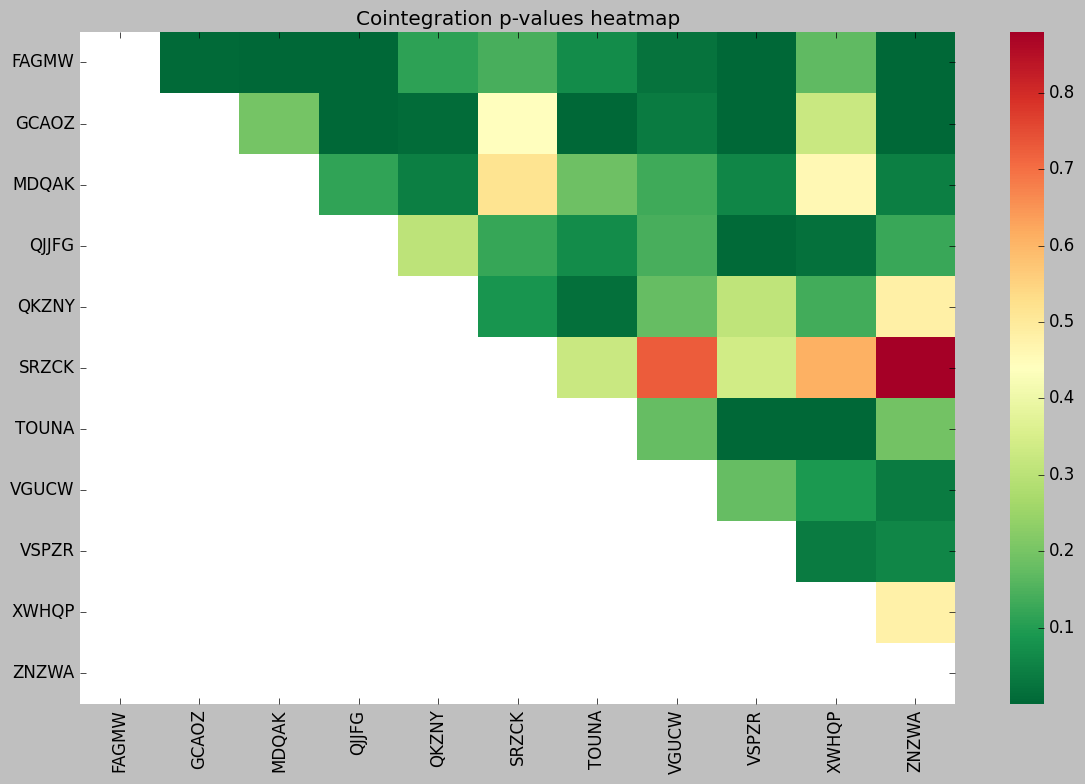

Analyzing pairs: 100%|██████████| 190/190 [00:03<00:00, 58.95it/s]



Analysis complete!
Found 65 cointegrated pairs
Total pairs analyzed: 190

Cluster 8 pairs:
AFIWZ - IPFFB
AFIWZ - IXUWX
AFIWZ - LAIRK
AFIWZ - QAHFT
AFIWZ - QIVTR
AFIWZ - SIPNK
AFIWZ - VZCAI
AFIWZ - WGELK
AFIWZ - ZQORV
ATIYU - KPNYF
ATIYU - LAIRK
ATIYU - MFKBJ
ATIYU - QAHFT
ATIYU - QIVTR
ATIYU - SIPNK
ATIYU - WGELK
CUWPD - IPFFB
CUWPD - VZCAI
GYLWO - KPNYF
GYLWO - LHAUQ
GYLWO - MFKBJ
GYLWO - QIVTR
GYLWO - UJLJN
GYLWO - WGELK
GYLWO - ZQORV
IPFFB - QAHFT
IPFFB - VZCAI
IPFFB - WGELK
IPFFB - XCKAF
IXUWX - QAHFT
IXUWX - SIPNK
IXUWX - WGELK
KPNYF - LAIRK
KPNYF - LHAUQ
KPNYF - UJLJN
KTOPF - LHAUQ
KTOPF - XCKAF
LAIRK - QIVTR
LAIRK - SIPNK
LAIRK - WGELK
LHAUQ - QAHFT
LHAUQ - QIVTR
LHAUQ - SIPNK
LHAUQ - VCWGM
LHAUQ - WGELK
LHAUQ - XCKAF
LHAUQ - ZQORV
MFKBJ - QAHFT
MFKBJ - QIVTR
MFKBJ - SIPNK
MFKBJ - UJLJN
MFKBJ - WGELK
MFKBJ - ZQORV
QAHFT - WGELK
QAHFT - XCKAF
QIVTR - SIPNK
QIVTR - UJLJN
QIVTR - ZQORV
SIPNK - UJLJN
SIPNK - WGELK
SIPNK - ZQORV
UJLJN - WGELK
UJLJN - XCKAF
UJLJN - ZQORV
VZCAI - XCKA

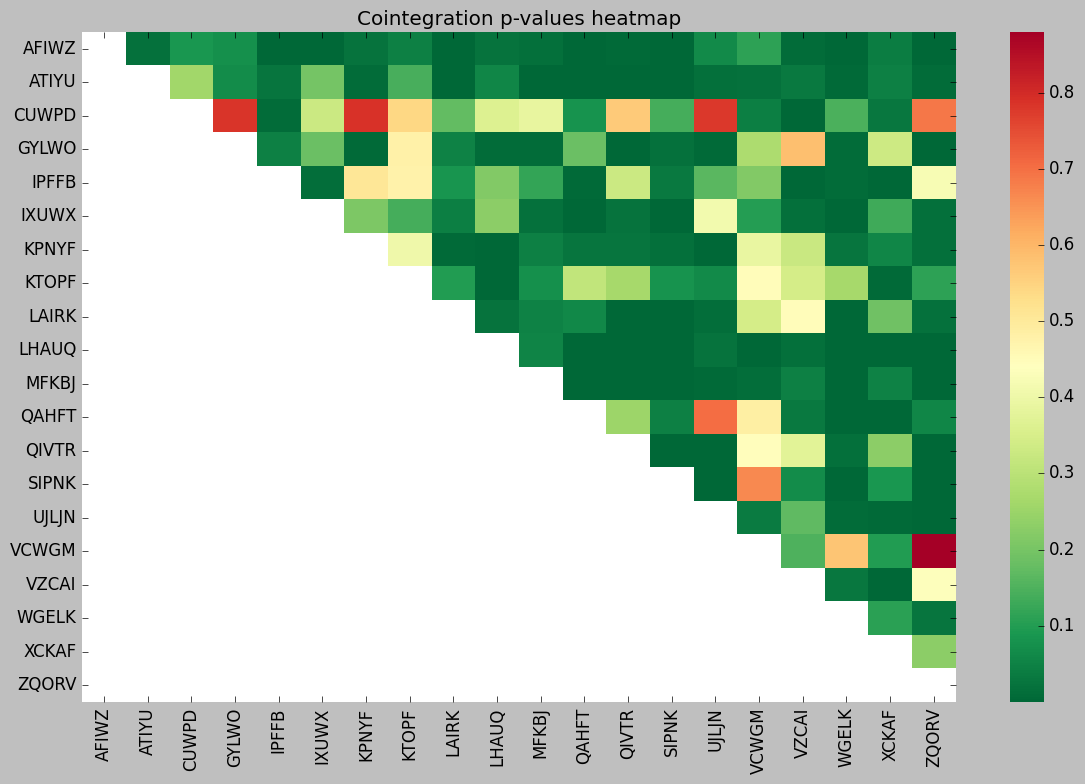

In [ ]:
all_pairs_with_clusters = []

for cluster_id in np.unique(ap.labels_):
    cluster_mask = ap.labels_ == cluster_id
    cluster_symbols = X.index[cluster_mask]
    
    if len(cluster_symbols) > 1:
        cluster_prices = price_matrix[cluster_symbols]
        score_matrix, pvalue_matrix, pairs, _ = analyze_pairs(
            cluster_prices,
            pvalue_threshold=0.05
        )
        
        if len(pairs) > 0:
            for pair in pairs:
                all_pairs_with_clusters.append({
                    'pair': pair,
                    'cluster': cluster_id
                })
            print(f"\nCluster {cluster_id} pairs:")
            for pair in pairs:
                print(f"{pair[0]} - {pair[1]}")
                
            plot_cointegration_heatmap(pvalue_matrix, cluster_symbols)

all_pairs = [item['pair'] for item in all_pairs_with_clusters]

In [91]:
stocks = np.unique([stock for pair in top_pairs for stock in pair])
X_data = pd.DataFrame(index=X.index, data=X).T  
in_pairs_series = pd.Series(index=stocks, data=[ap.labels_[list(X.index).index(stock)] for stock in stocks])
X_pairs = X_data.T.loc[stocks]

In [92]:

X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

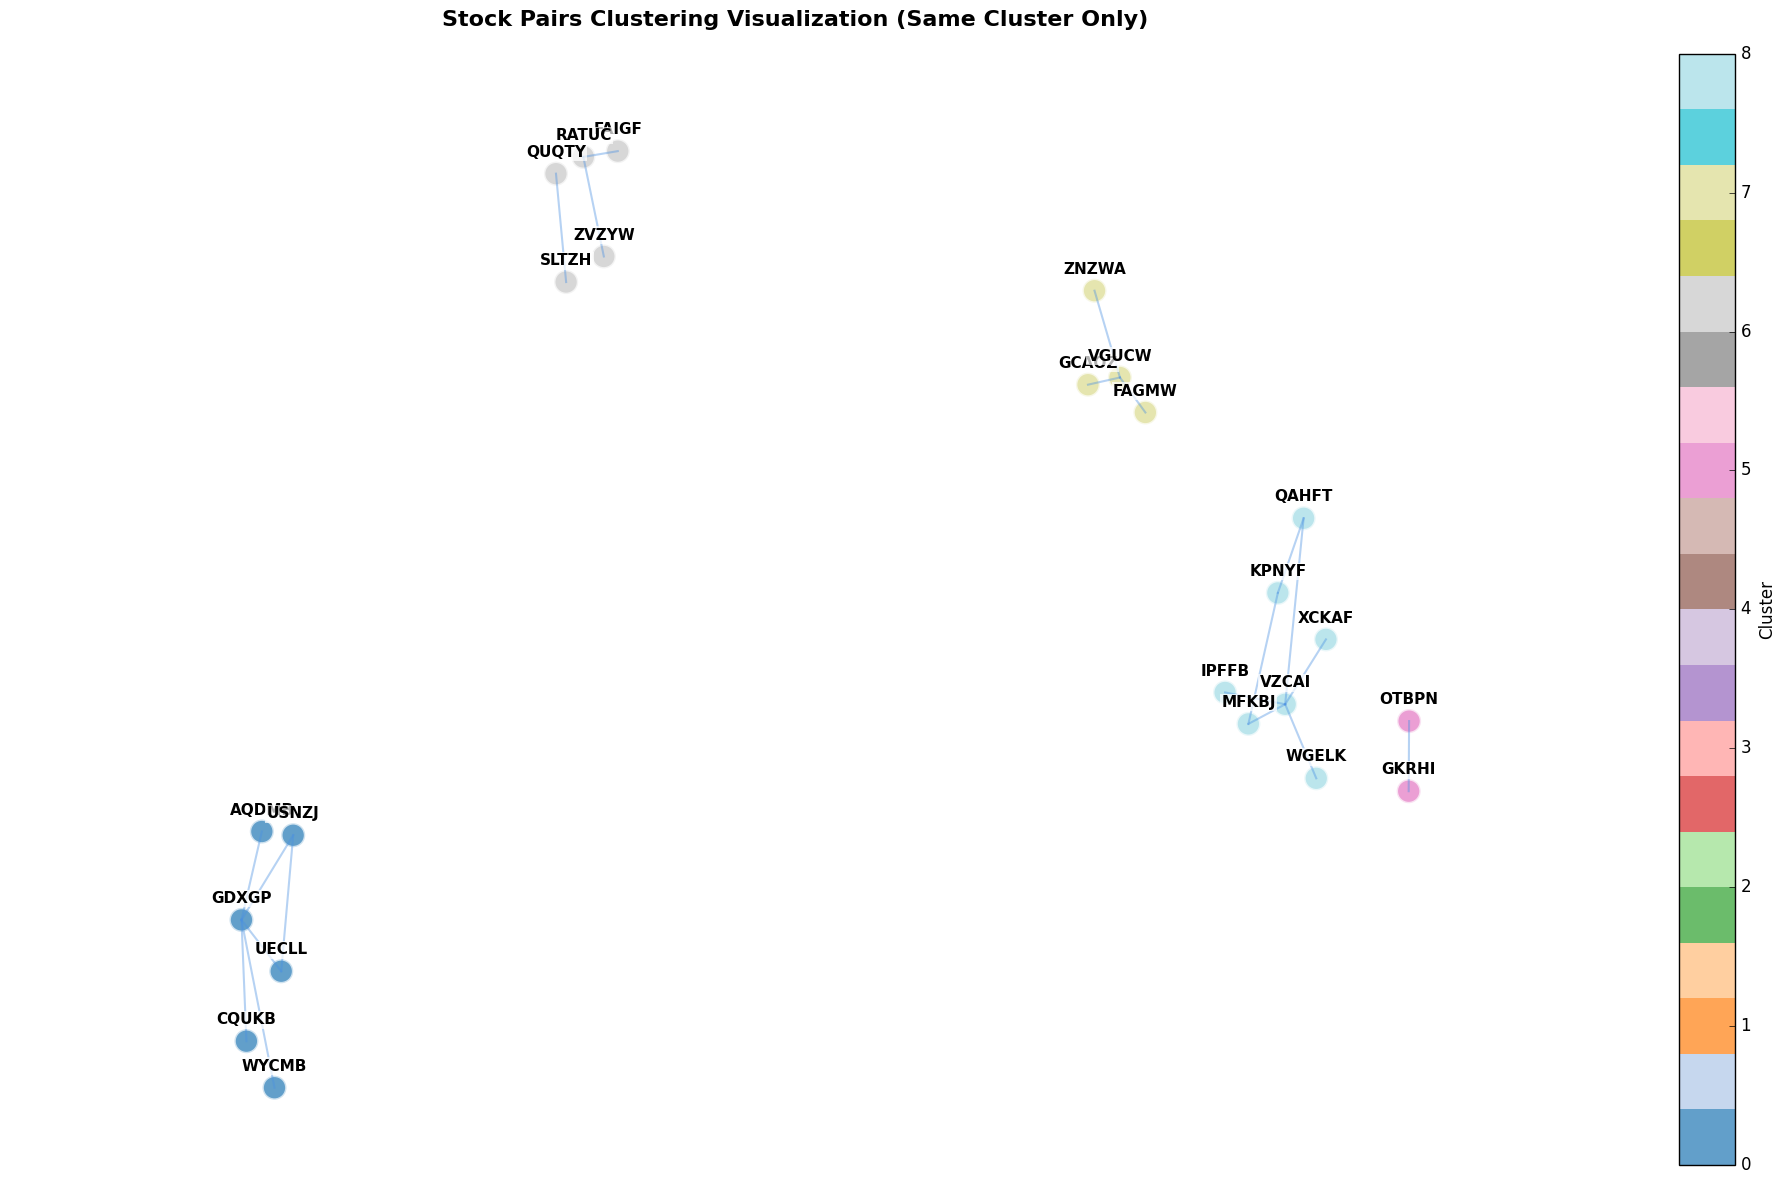

In [93]:

plt.figure(figsize=(20,12), facecolor='white')
plt.clf()
plt.gca().set_facecolor('#f8f9fa')
plt.grid(True, linestyle='--', alpha=0.7)

for pair in top_pairs:
    cluster = scores_df[scores_df['pair'] == pair]['cluster'].values[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    loc2 = X_pairs.index.get_loc(pair[1])
    x1, y1 = X_tsne[loc1, :]
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], '-', alpha=0.4, linewidth=1.5, color='#4a90e2')

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     s=300,
                     alpha=0.7,
                     c=in_pairs_series.values,
                     cmap='tab20',
                     edgecolor='white',
                     linewidth=2)

for x, y, name in zip(X_tsne[:,0], X_tsne[:,1], X_pairs.index):
    plt.annotate(name,
                (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                va='bottom',
                fontsize=11,
                fontweight='bold',
                bbox=dict(facecolor='white', 
                         edgecolor='none',
                         alpha=0.7,
                         pad=1))

plt.title('Stock Pairs Clustering Visualization (Same Cluster Only)', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.axis('off')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [94]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def calculate_spread(data, symbol1, symbol2, start_date=None, end_date=None):
    if start_date:
        mask = (data.index >= start_date) & (data.index <= end_date)
        data = data[mask]
    
    ratios = data[symbol1] / data[symbol2]
    zscore_ratios = zscore(ratios)
    
    return ratios, zscore_ratios

def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, window=50, std_dev=1.5):
    model = sm.OLS(S1_train, S2_train)
    hedge_ratio = model.fit().params[0]
    
    spread_test = S1_test - (S2_test * hedge_ratio)
    
    trades = []
    trade_id = 0
    position = 0
    entry_prices = None
    entry_date = None
    
    prev_spread = None
    
    for i in range(len(spread_test)):
        current_date = spread_test.index[i]
        current_spread = spread_test.iloc[i]
        
        rolling_mean = spread_test.iloc[:i+1].rolling(window=window, center=False).mean().iloc[-1]
        rolling_std = spread_test.iloc[:i+1].rolling(window=window, center=False).std().iloc[-1]
        
        upper_band = rolling_mean + (rolling_std * std_dev)
        lower_band = rolling_mean - (rolling_std * std_dev)
        
        if prev_spread is not None:
            if position == 0:
                if prev_spread > lower_band and current_spread < lower_band:
                    entry_date = current_date
                    entry_prices = {
                        symbol1: {"price": S1_test.iloc[i], "type": "long"},
                        symbol2: {"price": S2_test.iloc[i], "type": "short"}
                    }
                    position = 1
                    
                elif prev_spread < upper_band and current_spread > upper_band:
                    entry_date = current_date
                    entry_prices = {
                        symbol1: {"price": S1_test.iloc[i], "type": "short"},
                        symbol2: {"price": S2_test.iloc[i], "type": "long"}
                    }
                    position = -1
                    
            elif ((position == 1 and prev_spread < upper_band and current_spread > upper_band) or 
                  (position == -1 and prev_spread > lower_band and current_spread < lower_band)):
                
                for symbol in [symbol1, symbol2]:
                    trades.append({
                        'trade_id': trade_id,
                        'symbol': symbol,
                        'entry_date': entry_date,
                        'entry_price': entry_prices[symbol]["price"],
                        'exit_date': current_date,
                        'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                        'position_type': entry_prices[symbol]["type"],
                        'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                        'exit_type': 'target'
                    })
                position = 0
                trade_id += 1
                
        prev_spread = current_spread
            
    return trades

def backtest_pairs(price_matrix, pairs, train_end_date):
    all_trades = []
    
    for symbol1, symbol2 in pairs:
        training_mask = price_matrix.index < train_end_date
        
        S1_train = price_matrix[symbol1][training_mask]
        S2_train = price_matrix[symbol2][training_mask]
        S1_test = price_matrix[symbol1][~training_mask]
        S2_test = price_matrix[symbol2][~training_mask]
        
        pair_trades = trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2)
        all_trades.extend(pair_trades)
    
    trades_df = pd.DataFrame(all_trades)
    trades_df.to_parquet('../../data/results/Cluster_Bollinger.parquet')
    
    return trades_df

In [95]:
trades_df = backtest_pairs(price_matrix, top_pairs, DATE_CONFIG['TRAIN_END'])